# Using unlabelled, unfractionated datasets obtained from QExact and VOrbi instruments
* Datasets were searched against H_sapiens_Uniprot_SPROT_2017-04-12, Tryp_Pig_Bov sequence files using MSGFPlus
* Combined results with MASIC results (Q <= 0.01) to get quantitation data

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import Classification_Utils as cu
import MaxQuant_Postprocessing_Functions as mq
import numpy as np
from os import listdir
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn import preprocessing

## Load (and combine?) data from all tissues

In [3]:
files_dir = 'F:\Data_for_classifier\\'
file_paths = listdir(files_dir) 

df = cu.combine_csvs(files_dir, file_paths)

In [4]:
print(df.shape)
df.head()

(117884, 69)


,Blood_Plasma_CPTAC_TrypDige_undepleted_normal_19Apr13_Methow_13-02-13,Blood_Plasma_Darpa_2_human_02_23Jan17_Arwem_16-10-25,Blood_Plasma_OMICS_EBV_HP_UW001_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW002_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW003_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW004_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW005_8Apr16_Arwen_16-01-03,Blood_Plasma_RZHJ_012_16Jun10_Owl_10-02-04,Blood_Plasma_Trypsin_Digestion_Step5_Sample1_4Mar13_Lynx_13-02-11,Blood_Plasma_Trypsin_Digestion_Step5_Sample2_4Mar13_Lynx_13-02-11,...,Substantia_Nigra_Vorbi_1,Substantia_Nigra_Vorbi_2,Substantia_Nigra_Vorbi_3,Substantia_Nigra_Vorbi_4,Substantia_Nigra_Vorbi_5,Substantia_Nigra_Qexact_1,Substantia_Nigra_Qexact_2,Substantia_Nigra_Qexact_3,Substantia_Nigra_Qexact_4,Substantia_Nigra_Qexact_5
Peptide,,,,,,,,,,,,,,,,,,,,,
\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
\n-.DIQM*TQSPSTLSASVGDR.V,111460000.0,4776900.0,NaN,6.740800e+08,1.013200e+09,NaN,201570000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
\n-.DIQM*TQSPSTLSASVGDRVTITCR.A,NaN,NaN,NaN,1.665500e+09,1.889800e+09,NaN,750580000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
\n-.DIQMTQSPS.T,113990000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
\n-.DIQMTQSPSTLSASVGDR.V,87789000.0,271390000.0,NaN,NaN,2.841000e+09,NaN,217430000.0,NaN,12897000.0,29051000.0,...,NaN,NaN,NaN,138110000.0,NaN,NaN,NaN,NaN,NaN,NaN


## Clean data
* Log2 transform
* Mean/Median normalize
* Impute missing values

In [5]:
mq.log2_normalize(df)

df_min = df.min().min()
impute_val = df_min/2
df = df.fillna(impute_val)

# mean normalize
#df = (df - df.mean())/df.std()

# median normalize
mq.median_normalize(df)

C:\Users\kush494\Documents\Proteomics_Data_Processing\MaxQuant_Postprocessing_Functions.py:149: RuntimeWarning: divide by zero encountered in log2
  df.iloc[:,:] = np.log2(df.iloc[:,:])


## Map each column to a corresponding label

In [6]:
tissues = ['Blood_Plasma', 'Blood_Serum', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra']
            
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)
#tissues_to_columns

In [7]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

# Sort columns by tissue type for visualization purposes

## Visualize data
* Normalized boxplots
* Scree plot
* PCA plot
* Pearson Matrix

In [27]:
image_dir = r'D:\Images\Human_Tissues\\'

column_to_color = mq.map_colors(tissues, tissues_to_columns, 7)

In [20]:
mq.make_seaborn_boxplot(df, image_dir, 'Median_normalized_boxplots', column_to_color)

In [28]:
#scaled_data = preprocessing.scale(df.T)
scaled_data = df.T

pca = PCA() # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for dataframe

per_var, pca_labels = mq.make_scree_plot(pca, image_dir)
#mq.draw_pca_graph2(column_names, pca_data, image_dir, column_to_color, per_var, pca_labels, tissues, tissues_to_columns)
mq.draw_pca_graph(column_names, pca_data, image_dir, column_to_color, per_var, pca_labels, 'PCA_Median_Normalized_Annotated')

In [11]:
mq.make_pearson_matrix(df, image_dir)

## Test various classifiers using cross-validation

In [9]:
NUM_FOLDS = 8
transformed_df = df.T

### Decision Tree

In [9]:
dt = cu.decisiontree_model_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 0.78571429  0.92307692  0.57142857  0.85714286  0.85714286  0.71428571
  1.          0.85714286]
Accuracy: 0.82 (+/- 0.25)


### KNN

In [10]:
knn = cu.knn_model_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 0.71428571  0.92307692  1.          1.          0.71428571  0.71428571
  0.71428571  1.        ]
Accuracy: 0.85 (+/- 0.27)


### Logistic Regression

In [9]:
lr = cu.logistic_regression_model_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 0.92857143  0.92307692  1.          1.          1.          0.85714286
  1.          1.        ]
Accuracy: 0.96 (+/- 0.10)


### Naive Bayes
* Gaussian
* Multinomial

In [12]:
gnb = cu.bayes_gaussian_model_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 1.          1.          1.          1.          1.          0.85714286
  1.          1.        ]
Accuracy: 0.98 (+/- 0.09)


In [13]:
mnb = cu.bayes_multinomial_model_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 1.          0.92307692  1.          1.          1.          0.85714286
  1.          1.        ]
Accuracy: 0.97 (+/- 0.10)


### SVC variations

In [14]:
svc = cu.SVC_models_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 0.92857143  1.          1.          1.          1.          0.85714286
  1.          1.        ]
Accuracy: 0.97 (+/- 0.10)
Scores: [ 0.92857143  0.92307692  1.          1.          1.          0.85714286
  0.85714286  1.        ]
Accuracy: 0.95 (+/- 0.12)
Scores: [ 0.14285714  0.15384615  0.14285714  0.14285714  0.14285714  0.14285714
  0.14285714  0.14285714]
Accuracy: 0.14 (+/- 0.01)
Scores: [ 0.92857143  0.92307692  0.85714286  1.          0.85714286  0.85714286
  0.85714286  1.        ]
Accuracy: 0.91 (+/- 0.12)


### Aggregations
* Random Forest
* Gradient Boosting

In [10]:
rf = cu.randomforest_model_crossval(transformed_df, labels, NUM_FOLDS)

Scores: [ 1.          0.92307692  1.          1.          1.          0.85714286
  0.85714286  1.        ]
Accuracy: 0.95 (+/- 0.12)


In [16]:
gbc = cu.gradient_boosting_crossval(transformed_df, labels, NUM_FOLDS)

KeyboardInterrupt: 

## Tune parameters of best models 
* Check accuracy score and F1 score (measure of precision and recall)

In [17]:
import time
start_time = time.time()

--- 0.0 seconds ---


### Gradient Boosting grid search

In [18]:
gbc_grid = cu.gbc_grid_search(NUM_FOLDS, 1)

gbc_grid.fit(transformed_df, labels)

print('Best Gradient Boosting parameters:\n', gbc_grid.best_params_)
print('\nBest Cross-Validation score:\n', gbc_grid.best_score_)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

Best Random Forest parameters:
 {'classify__max_depth': 15, 'classify__min_samples_split': 2, 'classify__n_estimators': 200, 'reduce_dim': SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=None), 'reduce_dim__estimator': ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False

### Random Forest grid search

In [ ]:
rf_grid = cu.rf_grid_search(NUM_FOLDS, 1)

rf_grid.fit(transformed_df, labels)

print('Best Random Forest parameters:\n', rf_grid.best_params_)
print('\nBest Cross-Validation score:\n', rf_grid.best_score_)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\k

Best Random Forest parameters:
 {'classify__max_features': 'log2', 'classify__min_samples_split': 2, 'classify__n_estimators': 25, 'reduce_dim': SelectPercentile(percentile=75,
         score_func=<function f_classif at 0x000000000C365840>), 'reduce_dim__percentile': 75}

Best Cross-Validation score:
 1.0
--- 2494.6367796699205 minutes ---


### SVC grid search

In [ ]:
svc_grid = cu.svc_grid_search(NUM_FOLDS, 1)

svc_grid.fit(transformed_df, labels)

print('Best SVC parameters:\n', svc_grid.best_params_)
print('\nBest Cross-Validation score:\n', svc_grid.best_score_)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

## PCA of data reduced according to best grid search reduction method

In [10]:
from sklearn.feature_selection import SelectPercentile

percentile_75_df = SelectPercentile(percentile=75).fit_transform(transformed_df, labels)
percentile_75_df.shape

(69, 88413)

In [11]:
pca_percentile = PCA() # create a PCA object
pca_percentile.fit(percentile_75_df) # do the math
pca_data_percentile = pca_percentile.transform(percentile_75_df) # get PCA coordinates for dataframe

per_var_percentile, pca_labels_percentile = mq.make_scree_plot(pca_percentile, image_dir, 'Scree_75_Percentile')
mq.draw_pca_graph2(column_names, pca_data_percentile, image_dir, column_to_color, per_var_percentile, pca_labels_percentile, tissues, tissues_to_columns, 'PCA_75_Percentile')

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


## Top expressed peptides per tissue

In [11]:
cu.print_top_n_features(df, rf, 10)
cu.print_top_n_features_coef(df, lr, 10, tissues)

Feature ranking:

K.DKEPEVVFIGDSLVQLMHQCEIWR.E (0.023921)
K.EAIGAVIHYLLQVGSEK.Q (0.023536)
K.QGQYSPMAIEEQVAVIYAGVR.G (0.021591)
Y.SLSSTLTLSK.A (0.020224)
I.AGGPGNPALAEPLIQNVR.K (0.020002)
I.SSALQAGTVWVNCYGVVSAQCPFGGFK.M (0.019917)
K.FDPLVILK.T (0.019816)
R.SGPFGQIFRPDNFVFGQSGAGNNWAK.G (0.019756)
K.FDLLEELVAK.E (0.019736)
R.TLAFPLTIR.C (0.019404)Feature ranking:
Blood_Plasma: 
K.TITLEVEPSDTIENVK.A 
K.YICENQDSISSK.L 
R.LGEDNINVVEGNEQFISASK.S 
K.SAYPGQITSN.M 
R.WVDIALECER.Y 
K.VDNALQSGNSQESVTEQDSK.D 
K.SSGTSYPDVLK.C 
K.SIVHPSYNSN.T 
R.YGFIEGHVVIPR.I 
K.AGFAGDDAPR.A


Blood_Serum: 
K.IITHPNFNGNTLDNDIMLIK.L 
K.LSSPATLNSR.V 
K.IITHPNFNGNTLDNDIM*LIK.L 
R.GGSTSYGTGSETESPR.N 
R.ALTVPELTQQMFDAK.N 
K.QVGSGVTTDQVQAEAK.E 
K.NMQDMVEDYR.N 
R.VATVSLPR.S 
R.IITHPNFNGNTLDNDIMLIRLSSPATLNSR.- 
R.VGAGAPVYLAAVLEYLTAEILELAGNAAR.D


Liver: 
R.LGEDNINVVEGNEQFISASK.S 
K.AVM*DDFAAFVEK.C 
R.FLEQQNQVLQTK.W 
K.AEFAEVSK.L 
K.STSGGTAALGCLVK.D 
K.IITHPNFNGNTLDNDIM*LIK.L 
Y.FYAPELLFFAK.R 
R.ASSIIDELFQDR.F 
R.WVDIALECER

## Save model
* Save array/dataframe of features (via joblib) along with final model
* Write script to classify new data-- load features and fit new data on them

In [10]:
# save the model to disk
filename = 'finalized_lr_model.sav'
joblib.dump(lr, open(filename, 'wb'))

In [10]:
filename = 'finalized_lr_model.sav'
# some time later...

# load the model from disk
loaded_model = joblib.load(open(filename, 'rb'))

fake_new_data = df.copy().add_suffix('_2')

In [12]:
pred_data = cu.fit_new_data(df, fake_new_data)

print(transformed_df.head(5))
print(pred_data.head(5))

pred = loaded_model.predict(pred_data)
result = loaded_model.score(pred_data, labels)
#result = loaded_model.predict(pred_data)

print(result)

Peptide                                                   \n  \
Blood_Plasma_CPTAC_TrypDige_undepleted_normal_1...  3.803443   
Blood_Plasma_Darpa_2_human_02_23Jan17_Arwem_16-...  3.803443   
Blood_Plasma_OMICS_EBV_HP_UW001_8Apr16_Arwen_16...  3.803443   
Blood_Plasma_OMICS_EBV_HP_UW002_8Apr16_Arwen_16...  3.803443   
Blood_Plasma_OMICS_EBV_HP_UW003_8Apr16_Arwen_16...  3.803443   

Peptide                                             \n-.DIQM*TQSPSTLSASVGDR.V  \
Blood_Plasma_CPTAC_TrypDige_undepleted_normal_1...                  26.731951   
Blood_Plasma_Darpa_2_human_02_23Jan17_Arwem_16-...                  22.187643   
Blood_Plasma_OMICS_EBV_HP_UW001_8Apr16_Arwen_16...                   3.803443   
Blood_Plasma_OMICS_EBV_HP_UW002_8Apr16_Arwen_16...                  29.328345   
Blood_Plasma_OMICS_EBV_HP_UW003_8Apr16_Arwen_16...                  29.916272   

Peptide                                             \n-.DIQM*TQSPSTLSASVGDRVTITCR.A  \
Blood_Plasma_CPTAC_TrypDige_undepleted_no

##  Confusion matrices of best models' predictions on new data

Confusion matrix, without normalization
[[10  0  0  0  0  0  0]
 [10  0  0  0  0  0  0]
 [10  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0]
 [10  0  0  0  0  0  0]
 [10  0  0  0  0  0  0]
 [10  0  0  0  0  0  0]]
Normalized confusion matrix
[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]]


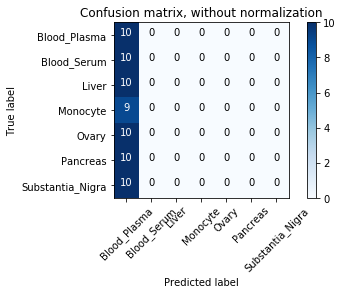

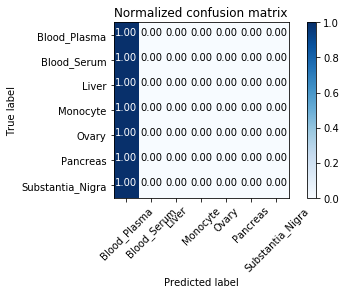

In [11]:
cu.show_confusion_matrices(labels, pred, tissues)